In [1]:
from scipy import stats
from numpy.random import binomial
from numpy.random import normal

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, ttest_rel
from scipy.stats import t, norm


In [2]:
df = pd.read_csv('data/hour.csv')

C:\Users\user\AppData\Local\Temp\ipykernel_14800\3406235526.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('temp_bin')['cnt'].mean().plot(


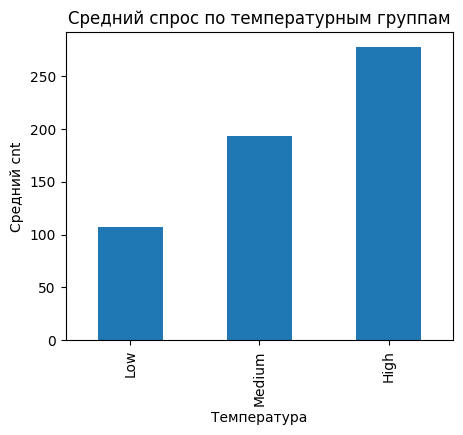

In [4]:
df['temp_bin'] = pd.qcut(
    df['temp'],
    q=3,
    labels=['Low', 'Medium', 'High']
)
df.groupby('temp_bin')['cnt'].mean().plot(
    kind='bar',
    figsize=(5,4)
)
plt.title('Средний спрос по температурным группам')
plt.xlabel('Температура')
plt.ylabel('Средний cnt')
plt.show()


Гипотеза 1

H₀: уровень спроса не отличается между рабочими и выходными днями

H₁: уровень спроса отличается между рабочими и выходными днями

Бизнес-смысл

планирование ребалансировки

разные сценарии для будней и выходных

оптимизация операционных затрат

ТЕСТ Mann–Whitney U

Почему:

две независимые выборки

распределение cnt не нормальное

сравнение центральных тенденций

In [5]:
from scipy.stats import mannwhitneyu

work = df[df['workingday'] == 1]['cnt']
free = df[df['workingday'] == 0]['cnt']

u_stat, p_value = mannwhitneyu(work, free, alternative='two-sided')
print('Mann–Whitney U:', u_stat, 'p-value:', p_value)


Mann–Whitney U: 33565313.0 p-value: 0.005558471213270806


In [6]:
def cohens_d(a, b):
    return (a.mean() - b.mean()) / np.sqrt((a.var() + b.var()) / 2)

cohens_d(work, free)


np.float64(0.06590384321379379)

In [7]:
from scipy.stats import ttest_ind

t_stat, p_t = ttest_ind(
    work,
    free,
    equal_var=False
)
p_t

np.float64(4.249478377549554e-05)

Оба теста, основанные на разных статистических предпосылках, приводят к одному и тому же выводу о наличии статистически значимых различий между рабочими и нерабочими днями.

Несмотря на статистически значимые различия между рабочими и нерабочими днями, размер эффекта оказался очень малым. Это указывает на то, что различия в среднем уровне спроса не являются выраженными, а статистическая значимость во многом обусловлена большим объёмом выборки.

Анализ показал, что хотя различия в среднем спросе между рабочими и нерабочими днями статистически значимы, их практическая величина крайне мала. Это означает, что при планировании ресурсов ключевым фактором является не тип дня сам по себе, а суточная структура спроса и временные пики активности пользователей.


Гипотеза 2

H₀: средний спрос не зависит от погодных условий

H₁: плохая погода статистически значимо снижает спрос

Бизнес-смысл

    прогноз выручки

    динамическое ценообразование

    маркетинговые кампании «плохой погоды»

ТЕСТ — Kruskal–Wallis

Почему:

2 групп

категориальный фактор

непараметрический тест

In [8]:
from scipy.stats import kruskal

groups = [
    df[df['weathersit'] == w]['cnt']
    for w in sorted(df['weathersit'].unique())
]

h_stat, p_value = kruskal(*groups)
print('Kruskal–Wallis H:', h_stat, 'p-value:', p_value)


Kruskal–Wallis H: 397.0308748666819 p-value: 9.733810896172332e-86


Kruskal–Wallis H = 397

p-value ≈ 10⁻⁸⁶


H₀ уверенно отвергается

Погодные условия сильно влияют на спрос

Различия между группами очень значимы



Бизнес-вывод

    Несмотря на статистически значимое влияние погодных условий на спрос, размер эффекта оказался малым (η² ≈ 0.023), что указывает на то, что погода является важным, но не определяющим фактором спроса. Для принятия операционных решений погодный фактор следует учитывать в сочетании с временными и календарными характеристиками.


Гипотеза 3 — монотонное влияние температуры
Формулировка

H₀: средний спрос на велосипеды не зависит от температуры

H₁: с ростом температуры средний спрос на велосипеды увеличивается

Бизнес-цель гипотезы 3

Понять, насколько и как температура влияет на спрос, чтобы:

прогнозировать загрузку сервиса;

планировать количество доступных велосипедов;

управлять операционными затратами (перераспределение, обслуживание, персонал)

корреляция Спирмена

Почему:

температура — непрерывная

связь монотонная

не предполагаем линейность и нормальность

In [9]:
from scipy.stats import spearmanr

rho, p_value = spearmanr(df['temp'], df['cnt'])
rho, p_value


(np.float64(0.4233295244770643), np.float64(0.0))

Корреляционный анализ Спирмена выявил статистически значимую положительную связь между температурой и спросом на велосипеды (h ≈ 0.42, p < 0.001). Это означает, что с ростом температуры среднее количество поездок увеличивается, однако температура объясняет лишь часть вариации спроса, что указывает на влияние дополнительных факторов.